# Corona status in Finland

<i>Calculations by Reima Tuhkanen, reima.tuhkanen@intellinord.com, 2020-03-15</i>

Almost all COVID-19 cases in Finland are tested before 14.3.2020. It is known, that all the cases have not been tested, even if the person had symptoms of the disease, but the other criteria have not been met. How ever data is useful. <BR>
    
The disease will spread if preventive measures are not taken, ie social contacts are not minimized.<BR>
 

### Comments of this study

This study is based purely on math. No machine learning is used. It is also good to know, that when 60% of population has had the virus spread speed will decrease and when immunity level is about 90%, virus is not spreading any more. 

Sivun tiedot pohjautuvat Helsingin Sanomien julkaisemaan avoimeen dataan Suomen koronavirus-tartunnoista. HS on kerännyt aineiston julkisista lähteistä: tiedotustilaisuuksista, mediasta ja haastatteluista. Dataa päivitetään aina kun uusia tietoja tulee. https://github.com/HS-Datadesk/koronavirus-avoindata

In [266]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
import urllib.request as request
import json
import datetime
from scipy.optimize import curve_fit
from datetime import datetime, date, timedelta
import time
import matplotlib.dates as mdates

In [267]:
def func(x, a, b, c):
    return a * np.exp(b * x) + c

### Finnish Corona data from open data

In [268]:
url = 'https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData'

In [269]:
 with request.urlopen(url) as response:
        source = response.read()
        data = json.loads(source)

In [270]:
newdata = data['confirmed']
df = pd.DataFrame.from_dict(newdata)

In [271]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date

### Chinese case in Lapland was separate case. We can drop that.

In [272]:
df = df[df['infectionSourceCountry'] != 'CHN']
df.sort_values('date',inplace = True)
df.tail()

,id,date,healthCareDistrict,infectionSourceCountry,infectionSource
253,256,2020-03-16,HUS,None,unknown
254,257,2020-03-16,HUS,None,unknown
256,259,2020-03-16,HUS,None,unknown
249,252,2020-03-16,HUS,None,unknown
276,279,2020-03-16,Pirkanmaa,None,unknown


In [273]:
df1 = df.groupby('date').size().reset_index(name='New Cases')
df1 = df1.set_index(['date'])
df1['Cum'] = df1.cumsum()


### Drop current day, statistics for the current day is not ready

(array([737482., 737484., 737485., 737487., 737489., 737491., 737493.,
        737495., 737497., 737499.]), <a list of 10 Text xticklabel objects>)

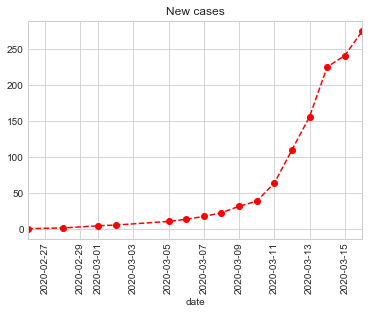

In [274]:
#df1 = df1[:-1]
ax = df1['Cum'].plot(style='ro--', title='New cases')
ax.set_xlabel('date')
plt.xticks(rotation=90)

In [275]:
df1.reset_index(inplace = True)

In [276]:
df1['days'] = df1['date'].shift(-1) - df1['date']
df1['Cumdays'] = df1['days'].cumsum()
df1['Cumdays2'] = df1['Cumdays'].shift(1)
df1['Cumdays2'] = df1['Cumdays2'] / np.timedelta64(1, 'D')
df1 = df1.fillna(0.0)
df1.drop(['days', 'Cumdays'], axis=1, inplace=True)
df1.columns = ['date','New Cases','Cum','day']
df1.head(20)
df_malli = df1[df1['day']<18]
df_havainnot = df1[df1['day']>=18]


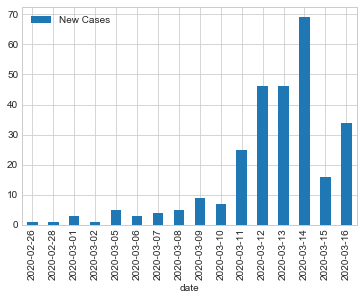

In [277]:
df1.plot(kind='bar',x='date',y='New Cases')

In [278]:
df_malli.dtypes

date          object
New Cases      int64
Cum            int64
day          float64
dtype: object

In [279]:
x = df_malli['day']
y = df_malli['Cum']
popt, pcov = curve_fit(func, x, y)
popt


array([0.22234472, 0.4069623 , 2.98508766])

### Cumulative cases fitted to function

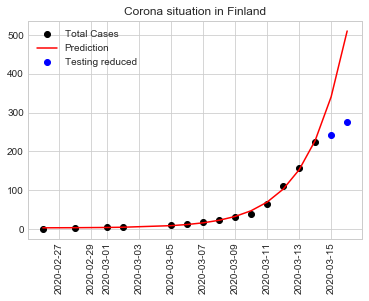

In [280]:
plt.figure()
plt.plot(df_malli['date'], y, 'ko', label="Total Cases")
plt.plot(df1['date'], func(df1['day'], *popt), 'r-', label="Prediction")
plt.plot(df_havainnot['date'],df_havainnot['Cum'], 'bo', label="Testing reduced")
plt.title('Corona situation in Finland')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [281]:
def predictTotal(Date,model):
    
    date_format = "%d.%m.%Y"
    start_date = datetime.strptime('26.02.2020', date_format)
    pred_date = datetime.strptime(Date, date_format)
    
    x = (pred_date-start_date).days
    return round(func(x, *model))

   

### How many cases there will be on some specific day?

In [282]:
note = ""
today = date.today()
for i in range(15):
    end_date = today + timedelta(days=i)
    day2 = end_date.strftime("%d.%m.%Y")
    prediction = predictTotal(day2,popt)
    if prediction > 74000:
        note = " China 18.2.2018. deaths 2000"
    elif prediction > 20000:
        note = " "
    elif prediction > 14800:
        note = " Hubei for Feb. 12: 14,840 new cases and 242 new deaths."
    elif prediction > 12800:
        note = " Italy 12.3.20200, deaths 1000."
    elif prediction > 12000:
        note = " Italy shut down 11.3.2020."
    elif prediction > 9000:
        note = " Italy strict quarantine measures extended to all regions. 9.3.2020"
    elif prediction > 6000:
        note = " Northern Italy under lockdown. 8.3.2020"
    elif prediction > 5000:
        note = " Entire region of Lombardy is in lockdown. 7.3.2020"
    elif prediction > 1000:
        note = ""
    elif prediction > 700:
        note = " First death has happen at least when there has been over 800 cases."
    print(day2 + " cumulative cases: " + str(prediction) + note)

16.03.2020 cumulative cases: 510.0
17.03.2020 cumulative cases: 765.0 First death has happen at least when there has been over 800 cases.
18.03.2020 cumulative cases: 1147.0
19.03.2020 cumulative cases: 1722.0
20.03.2020 cumulative cases: 2586.0
21.03.2020 cumulative cases: 3883.0
22.03.2020 cumulative cases: 5832.0 Entire region of Lombardy is in lockdown. 7.3.2020
23.03.2020 cumulative cases: 8759.0 Northern Italy under lockdown. 8.3.2020
24.03.2020 cumulative cases: 13157.0 Italy 12.3.20200, deaths 1000.
25.03.2020 cumulative cases: 19763.0 Hubei for Feb. 12: 14,840 new cases and 242 new deaths.
26.03.2020 cumulative cases: 29687.0 
27.03.2020 cumulative cases: 44596.0 
28.03.2020 cumulative cases: 66993.0 
29.03.2020 cumulative cases: 100639.0 China 18.2.2018. deaths 2000
30.03.2020 cumulative cases: 151183.0 China 18.2.2018. deaths 2000


### How many people are not aware having Corona today?

In [283]:
today = date.today()
end_date = today + timedelta(days=5)
day1 = today.strftime("%d.%m.%Y")
day2 = end_date.strftime("%d.%m.%Y")

print("Wash your hands, because " + str(predictTotal(day2,popt) - predictTotal(day1,popt)) + " people are out there without knowing having COVID-19!")

Wash your hands, because 3373.0 people are out there without knowing having COVID-19!
